In [14]:
import networkx as nx
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances # for the similarity graph

# ------- IMPLEMENT HERE ANY AUXILIARY FUNCTIONS NEEDED ------- #


# --------------- END OF AUXILIARY FUNCTIONS ------------------ #

In [15]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

def retrieve_bidirectional_edges(g: nx.DiGraph, out_filename: str) -> nx.Graph:
    undirected_graph = nx.Graph()
    for u, v in g.edges():
        if g.has_edge(v, u):
            undirected_graph.add_edge(u, v)
    
    nx.write_graphml(undirected_graph, out_filename)
    return undirected_graph

def prune_low_degree_nodes(g: nx.Graph, min_degree: int, out_filename: str) -> nx.Graph:
    pruned_graph = g.copy()
    nodes_to_remove = [node for node, degree in dict(pruned_graph.degree()).items() if degree < min_degree]
    pruned_graph.remove_nodes_from(nodes_to_remove)

    zero_degree_nodes = [node for node, degree in dict(pruned_graph.degree()).items() if degree == 0]
    pruned_graph.remove_nodes_from(zero_degree_nodes)
    
    nx.write_graphml(pruned_graph, out_filename)
    return pruned_graph

def prune_low_weight_edges(g: nx.Graph, min_weight: float = None, min_percentile: int = None, out_filename: str = None) -> nx.Graph:
    if (min_weight is None and min_percentile is None) or (min_weight is not None and min_percentile is not None):
        raise ValueError("Specify exactly one of min_weight or min_percentile")
    
    pruned_graph = g.copy()
    if min_weight is not None:
        edges_to_remove = [(u, v) for u, v, w in pruned_graph.edges(data='weight') if w < min_weight]
    else:
        weights = [w for _, _, w in pruned_graph.edges(data='weight')]
        threshold = pd.Series(weights).quantile(min_percentile / 100.0)
        edges_to_remove = [(u, v) for u, v, w in pruned_graph.edges(data='weight') if w < threshold]
    
    pruned_graph.remove_edges_from(edges_to_remove)
    
    zero_degree_nodes = [node for node, degree in dict(pruned_graph.degree()).items() if degree == 0]
    pruned_graph.remove_nodes_from(zero_degree_nodes)
    
    if out_filename:
        nx.write_graphml(pruned_graph, out_filename)
    return pruned_graph

def compute_mean_audio_features(tracks_df: pd.DataFrame) -> pd.DataFrame:
    # Inspect the dataframe
    print("Dataframe columns and types:")
    print(tracks_df.dtypes)
    
    # Identify numeric columns for audio features
    numeric_columns = tracks_df.select_dtypes(include='number').columns
    print("Numeric columns identified for mean calculation:")
    print(numeric_columns)
    
    mean_features_df = tracks_df.groupby('artist_id')[numeric_columns].mean().reset_index()
    artist_names = tracks_df[['artist_id', 'artist_name']].drop_duplicates()
    mean_features_df = pd.merge(mean_features_df, artist_names, on='artist_id', how='left')
    return mean_features_df

def create_similarity_graph(artist_audio_features_df: pd.DataFrame, similarity: str, out_filename: str = None) -> nx.Graph:
    from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

    features = artist_audio_features_df.drop(['artist_id', 'artist_name'], axis=1).values
    if features.shape[1] == 0:
        raise ValueError("No features available for similarity calculation.")
    
    if similarity == 'cosine':
        similarity_matrix = cosine_similarity(features)
    elif similarity == 'euclidean':
        similarity_matrix = euclidean_distances(features)
    else:
        raise ValueError("Unsupported similarity metric. Use 'cosine' or 'euclidean'.")
    
    similarity_graph = nx.Graph()
    num_artists = len(artist_audio_features_df)
    for i in range(num_artists):
        for j in range(i + 1, num_artists):
            similarity_graph.add_edge(
                artist_audio_features_df.loc[i, 'artist_name'],
                artist_audio_features_df.loc[j, 'artist_name'],
                weight=similarity_matrix[i, j]
            )
    
    if out_filename:
        nx.write_graphml(similarity_graph, out_filename)
    return similarity_graph

def visualize_graph(g: nx.Graph, title: str):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(g, seed=42)
    nx.draw(g, pos, with_labels=True, node_size=50, font_size=10)
    plt.title(title)
    plt.show()


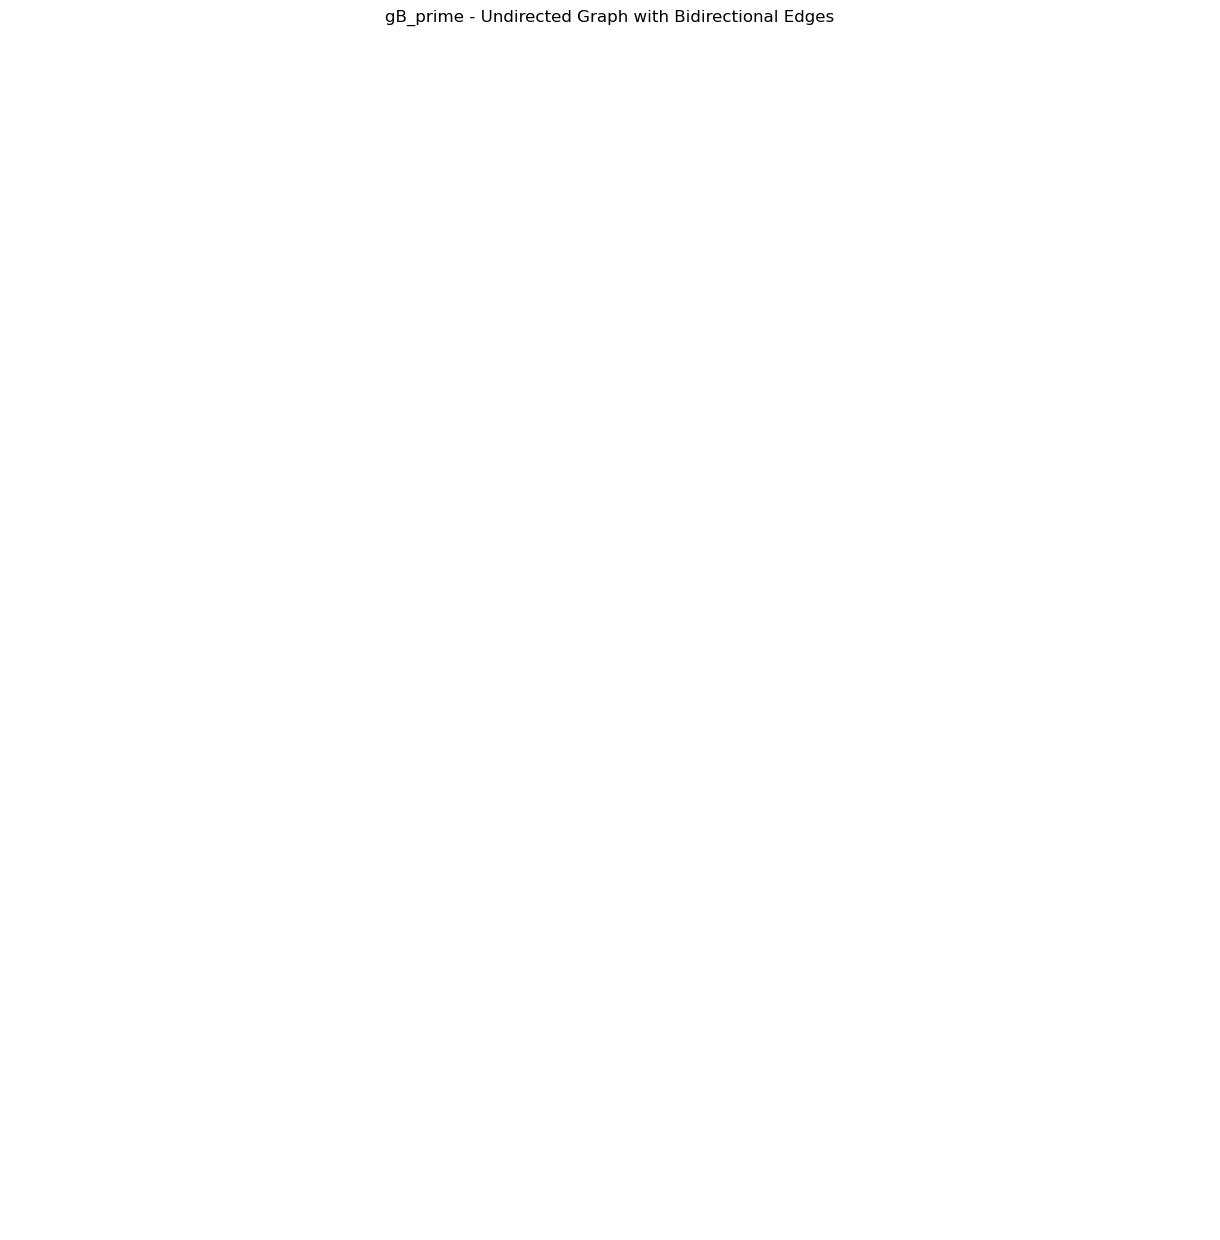

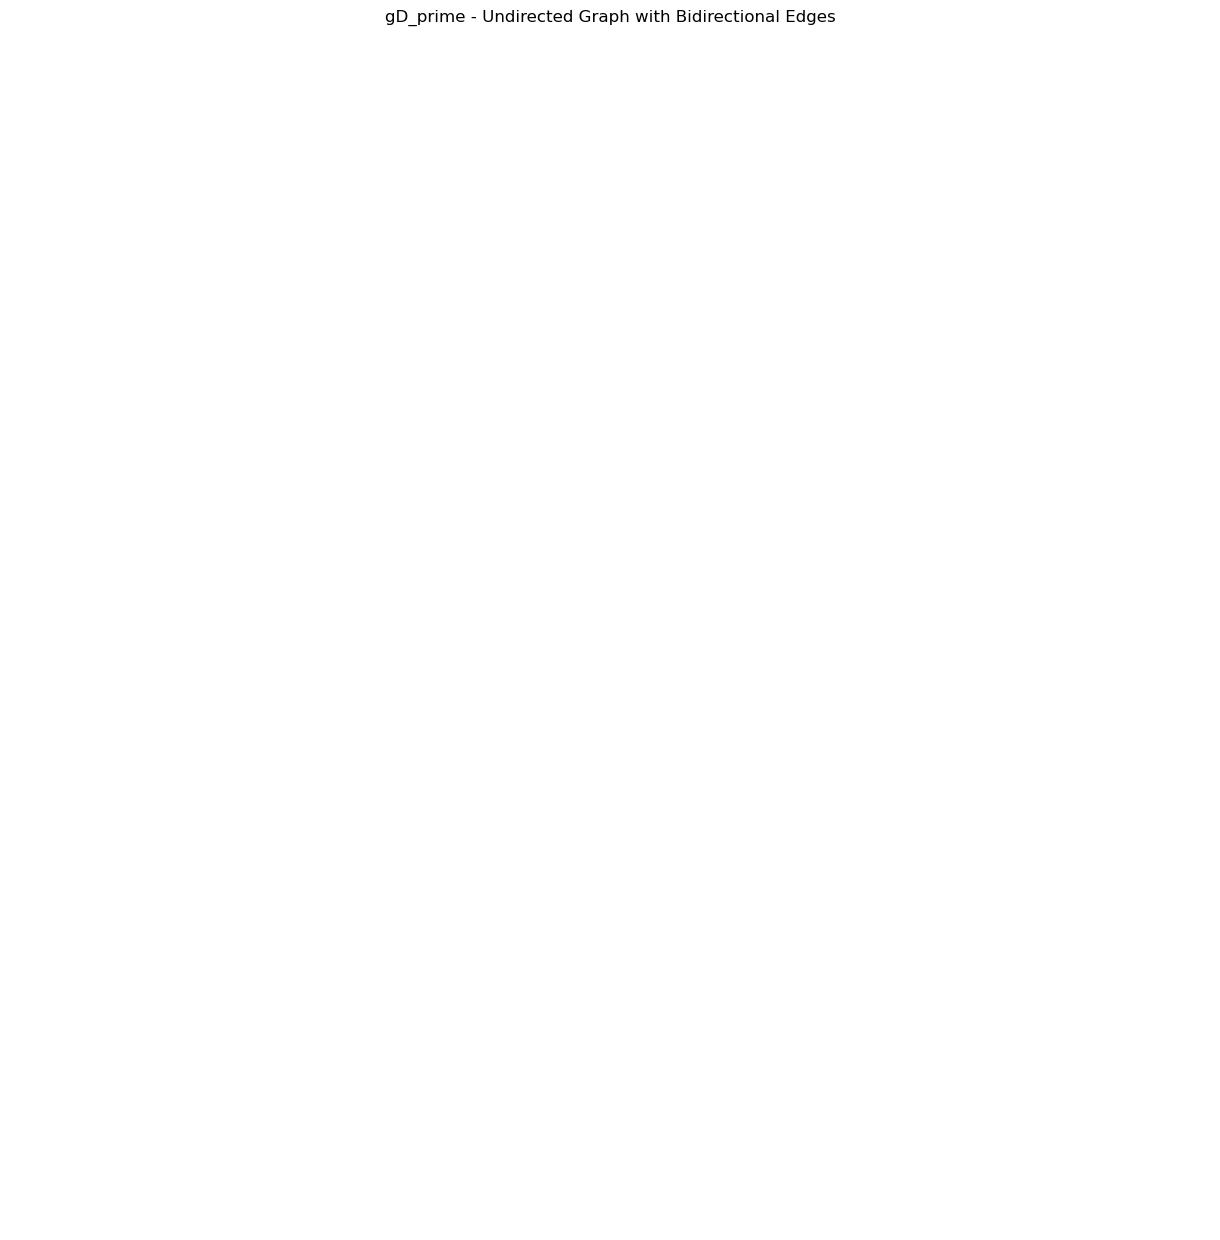

In [19]:

if __name__ == "__main__":
    # ------- IMPLEMENT HERE THE MAIN FOR THIS SESSION ------- #
    # Load the directed graphs
    gB = nx.read_graphml('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/gB.graphml')
    gD = nx.read_graphml('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/gD.graphml')
    
    
    # Task 6(a) - Generate undirected graphs with bidirectional edges
    gB_prime = retrieve_bidirectional_edges(gB, 'gBp.graphml')
    gD_prime = retrieve_bidirectional_edges(gD, 'gDp.graphml')
    visualize_graph(gB_prime, "gB_prime - Undirected Graph with Bidirectional Edges")
    visualize_graph(gD_prime, "gD_prime - Undirected Graph with Bidirectional Edges")
     # Load the song data
    tracks_df = pd.read_csv('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/songs.csv')
    
    # Task 6(b) - Generate similarity graph from average audio features
    #artist_mean_audio_features_df = compute_mean_audio_features(tracks_df)
    #gw = create_similarity_graph(artist_mean_audio_features_df, 'cosine', 'gw.graphml')
    
    # Display resulting graphs

    #visualize_graph(gw, "gw - Similarity Graph")
    
    # ------------------- END OF MAIN ------------------------ #
